# Классификация sms сообщений

In [0]:
%matplotlib inline
# служебная команда для отображения графиков

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


В этом задании мы будем использовать данные SMS Spam collection из репозитория UCI.
Файл с данными расположен [по ссылке](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/), скачайте и разархивируйте его.

### Загрузка, визуализация и предварительный анализ данных

Загрузим данные, используя модуль pandas:

In [0]:
import pandas as pd

pd.set_option('display.max_rows', 100)
# Display up to 100 columns of a dataframe

In [0]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/SMSSpamCollection", \
                  sep="\t", \
                  header=None,\
                  names=["label", "sms"])

Посмотрим первые десять строк:

In [6]:
data.head(10)

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


В первом столбце хранятся метки (спам или не спам), во втором - текст сообщения.

Посмотрим, сколько всего объектов:

In [7]:
len(data)

5572

Посмотрим, сколько объектов каждого класса:

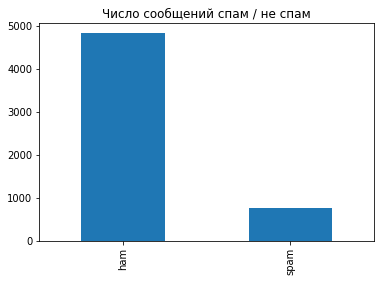

In [8]:
counts = data["label"].value_counts()
counts.plot(kind='bar', title="Число сообщений спам / не спам")

In [9]:
counts

ham     4825
spam     747
Name: label, dtype: int64

В выборке гораздо больше не-спама, чем спама.

### Предобработка данных

В данных пока что нет выделенных признаков. Для текстов можно использовать простое преобразование -- "мешок слов". Создадим словарь из всех слов, которые встречаются в sms. Для каждого объекта-текста мы получим столько признаков, сколько слов в словаре, и каждый признак содержит 1 (слово входит в текст) или 0 (слово не входит). Для этого в sklearn есть специальный инструмент:

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(data["sms"])

In [0]:
# слова в том порядке, в котором они идут в матрице X по столбцам
words = pd.Series(vectorizer.vocabulary_).sort_values().index

Сколько получилось объектов и признаков?

In [13]:
X.shape

(5572, 8713)

А что в самой матрице?

In [14]:
X[:10].todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

Мы почти не видим единиц в этой матрице, потому что их очень мало.

У нас есть еще одна небольшая проблема: классы обозначены не числами, а буквами. Перекодируйте "spam" в 1, а "ham" в 0 с помощью средств pandas и запишите в переменную y:

In [15]:
y = data['label'].replace({'spam': 1, 'ham': 0})
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int64

Теперь у нас есть X и y!

Разделите данные на обучение и контроль в пропорции 3:1:
То есть 75% на 25%

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

### Обучение линейной модели

Обучите логистическую регрессию:

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
LR = LogisticRegression(random_state=42,solver='liblinear')
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

Создайте датафрейм pandas с двумя столбцами: первый столбец - слова из словаря (определены выше), второй - веса этих слов (атрибут coef\_ модели, например,  model.coef\_). Отсортируйте датафрейм по возрастанию весов, выведите 100 слов с наибольшими весами и 100 слов с наименьшими (наибольшими по модулю отрицательными) весами. 

Внимание: веса модели имеют форму (1, num\_features), а нам нужно (num\_features,), поэтому потребуется использовать конструкцию вида model.coef\_[0].

In [20]:
ws = LR.coef_[0]
print(type(ws))

<class 'numpy.ndarray'>


In [21]:
df1 = pd.DataFrame({"words": words, "weights": ws})
df1.head()

,words,weights
0,00,0.384515
1,000,0.420801
2,000pes,-0.010206
3,008704050406,0.006450
4,0089,0.017851


In [0]:
df1 = df1.sort_values(by=['weights'])

In [23]:
df1.head(100)

,words,weights
3684,gt,-1.059909
4793,lt,-1.018166
5254,my,-1.016533
4968,me,-1.000621
4696,ll,-0.756478
7126,sorry,-0.734548
6516,right,-0.692565
3805,he,-0.691806
3436,fullonsms,-0.685031
4550,later,-0.645261


In [24]:
df1.tail(100)

,words,weights
2215,condition,0.536944
2458,dartboard,0.536944
7920,trebles,0.536944
2765,draw,0.550019
2371,cs,0.550325
1114,announcement,0.550339
7540,takes,0.555805
6631,sale,0.555880
5663,over,0.557309
8128,user,0.558039


Можно ли сказать, что топ слова действительно характеризуют каждый из двух классов? Почему?

Если мы знаем, что у нас точно есть два класса (спам, не спам), то благодаря просмотру первых и последних 100 слов упорядоченных по возрастанию веса мы можем сказать, что слова с большим (`tail`) весом относятся к спаму, а с меньшим(`head`) весом к не спаму. Это получается из-за характеристики `coef_` , так как при встрече слов `txt, ringtone, call, reply, won , ссылки на порносайты` это предложение будет соотнесено к спаму, а при встрече таких часто использующих в разговоре слов как `my, me, sorry, he, what` - к не спаму.

### Оценивание качества

Вычислите точность (accuracy) на обучающей и тестовой выборке:

In [0]:
from sklearn.metrics import accuracy_score

In [26]:
print(f'Accuracy score is {round(accuracy_score(y_test,y_pred),4)}')

Accuracy score is 0.9849


Поскольку в данных класс 1 редкий, лучше использовать точность и полноту. Посчитайте их для тестовой выборки:

In [0]:
from sklearn.metrics import classification_report

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       1.00      0.89      0.94       186

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.97      1393
weighted avg       0.99      0.98      0.98      1393



Какое утверждение верно? Поясните свой ответ.

1) Алгоритм находит почти все спамовые смс-сообщения, но иногда неверно включает в них неспамовые.

2) Все, что алгоритм отнес к спамовым смс-сообщениям, действительно является спамом. Однако алгоритм находит не все спамовые сообщения.

Зная теоретическую составляющую:

`precision` - показывает точность предсказания системы (если система сказала, что это спам, насколько ей можно доврять); 

`recall` - показывает полноту ответов системы (сколько спам сообщений она найдет из всех предъявленных спам сообщений). 

Утверждение 2 верное, так как `precision` = 1.00 , что значит доля объектов, названных классификатором спамом и при этом действительно являющимися спамом, а `recall` = 0.89 показывает, какую долю спам сообщений из всех сообщений спам класса нашел алгоритм

Постройте ROC-кривую для вашей обученной модели. Используйте предсказания на тестовой выборке. 
1. Вместо функции predict нужно использовать функцию predict_proba. Она вернет матрицу размера (число объектов, 2), для каждого объекта - вероятность класса 0 и вероятность класса 1.
1. Вам нужно извлечь вектор вероятностей класса 1 и использовать его для построения ROC-кривой.

In [0]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

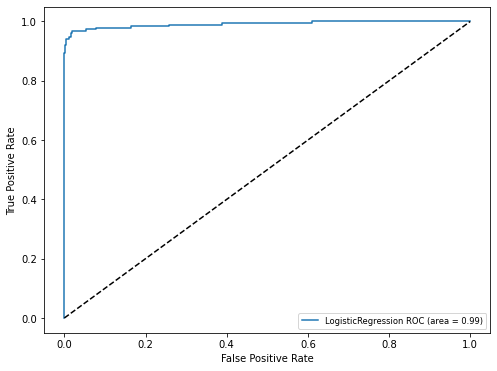

In [30]:
plt.figure(figsize=(8,6))

probas = LR.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()


### Подбор гиперпараметра - коэффициента регуляризации

В наших данных очень много признаков - столько, сколько слов с словаре. В линейных моделях есть специальный инструмент, позволяющий автоматически выбирать релевантные признаки - регуляризация, а точнее, Lasso (L1) регуляризация. При использовании регуляризации к функционалу качества, который оптимизируется при обучении линейной модели, прибавляется регуляризатор - сумма модулей весов, умноженная на коэффициент регуляризации. Коэффициент регуляризации задает силу регуляризатора: если коэффициент очень маленький, регуляризатор почти не меняет модель, если коэффициент очень большой, регуляризатор мешает модели настраиваться на данные. При достаточно большом коэффициенте Lasso-регуляризации большинство весов в модели становятся нулевыми, и соответствующие признаки не используются. Коэффициент регуляризации обычно подбирают, используя кросс-валидацию.

Сначала посмотрим, сколько нулевых весов в модели без регуляризации (та, которую вы уже обучили). Напомним, что веса модели хранятся в атрибуте coef\_ модели. Посчитайте с помощью numpy, каков процент весов, равных 0:

In [0]:
import numpy as np

In [32]:
zrs = np.count_nonzero(LR.coef_[0] == 0)
sh = LR.coef_[0].shape
print(f'Zero values percentage in coef_ tuple is {round(float(zrs)/float(sh[0])*100, 2)} %')

Zero values percentage in coef_ tuple is 14.04 %


Теперь обучите логистическую регрессию с коэффициентом Lasso-регуляризации по умолчанию. Для этого укажите penalty='l1' при создании объекта класса LogisticRegression:

In [0]:
LR_lasso = LogisticRegression(penalty='l1',random_state=42, solver='liblinear')
LR_lasso.fit(X_train, y_train)
y_pred_lasso = LR_lasso.predict(X_test)

Какой процент нулевых весов в новой модели?

In [34]:
zrs_lasso = np.count_nonzero(LR_lasso.coef_[0] == 0)
sh_lasso = LR_lasso.coef_[0].shape
print(f'Zero values percentage in coef_ tuple is {round(float(zrs_lasso)/float(sh_lasso[0])*100, 2)} %')

Zero values percentage in coef_ tuple is 97.85 %


Теперь подберем коэффициент регуляризации в помощью кросс-валидации. Для этого воспользуемся GridSearchCV:

In [0]:
from sklearn.model_selection import GridSearchCV

GridSearchCV имеет такой же интерфейс, как и классификатор, с фит-предикт. Но, в отличие от обычного классификатора, во время вызова fit обучается не одна модель, а несколько. Более подробно:
1. Для каждого варианта коэффициента регуляризации:
    1. Разделить выборку на несколько блоков
    2. Повторять несколько раз: выбрать один блок как тестовую выборку, все остальные - как обучающие. Обучить модель, вычислить качество на тестовом блоке.
    3. Усреднить качество по всем повторам с предыдущего шага.
2. Выбрать коэффициент регуляризации с лучшим средним качеством
3. Переобучить модель на всех обучающих данных с выбранным коэффициентом регуляризации.

В итоге, после вызова fit, в атрибуте .best\_estimator\_ будет храниться итоговая модель (с ней можно будет делать все то же самое, что с обычной логистической регрессией), а в атрибуте .grid\_scores\_ - история всех запусков.

Запишите в переменную model\_for\_cv модель логистической регрессии с выбранной регуляризацией "l1", а в переменную param\_grid - вектор коэффициентов регуляризации $1, 10, 100, \dots, 10^9$ (воспользуйтесь numpy).

In [36]:
model_for_gs = LogisticRegression(random_state=42, penalty = 'l1', solver ='liblinear')
param_grid = [int(x) for x in np.geomspace(1, 10**9, num=10, endpoint=True)]
gs = GridSearchCV(model_for_gs,
                  {"C":param_grid},
                  verbose=3)

gs.fit(X_train,y_train)

print("Best parameters are ", gs.best_params_)
print("Accuracy score is ", gs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.987, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.965, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.984, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.976, total=   0.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.988, total=   0.0s
[CV] C=10 ............................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ................................ C=10, score=0.984, total=   0.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.983, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.990, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.980, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.963, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.987, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.983, total=   0.0s
[CV] C=1000 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished


Построим график: коэффициент регуляризации - качество:

In [37]:
print(gs.cv_results_.keys())
print(gs.cv_results_['mean_test_score'])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
[0.97846317 0.9799003  0.980618   0.98061857 0.97654901 0.97032605
 0.9621895  0.95955763 0.95860012 0.95836089]


У меня установлена последняя версия scikit-learn и в нем нет метода `grid_search`. Придется переписывать код ручками, концепция останется такой же

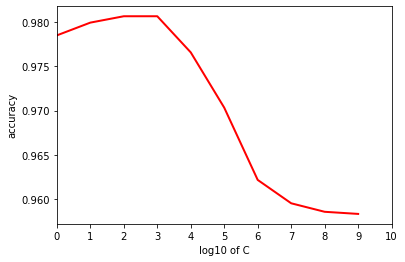

In [38]:
import matplotlib.ticker as ticker

x = np.log10(np.geomspace(1, 10**9, num=10, endpoint=True))
y = gs.cv_results_['mean_test_score']

fig, ax = plt.subplots()

ax.plot(x, y, color = 'r', linewidth = 2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlim([0.,10])
plt.xlabel("log10 of C")
plt.ylabel("accuracy")

plt.show()

Какое C оптимально? Что происходит при очень больших и маленьких С? Обратите внимание, что в логистической регрессии на самом деле коэффициент регуляризации равен $\frac 1 C$, то есть чем больше C, тем меньше коэффициент.

`GridSearchCV` выдало результат, что лучшим значением параметра $C$ является 1000. При больших и маленьких значениях $C$ (при ослаблении и увеличении регуляризации) модель недообучается. Оптимальным является С=1000 (десятичный логарифм числа 1000) = 3

Какова доля нулевых весов в модели с лучшим C? 

In [39]:
LR_hp = LogisticRegression(penalty='l1',random_state=42, solver='liblinear', C=1000)
LR_hp.fit(X_train, y_train)
y_pred_hp = LR_hp.predict(X_test)

zrs_hp = np.count_nonzero(LR_hp.coef_[0] == 0)
sh_hp = LR_hp.coef_[0].shape
print(f'Zero values percentage in coef_ tuple is {round(float(zrs_hp)/float(sh_hp[0])*100, 2)} %')

Zero values percentage in coef_ tuple is 93.52 %


Какое качество показывает модель с лучшим C на наших отложенных, тестовых данных?

In [40]:
print(classification_report(y_test,y_pred_hp))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.99      0.88      0.93       186

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



Сравните неразреженную (без регуляризации) и разреженную (с оптимальным C) модели по качеству на тестовой выборке и доле нулевых весов.

Можно увидеть, что `accuracy` у всех моделей одинаковая. И вообще модели отличаются друг от друга на сотые доли, но все равно у неразреженной модели показатели `precision` и `recall` выше. Больше всего нулевых весов в модели с коэффициентом Lasso-регуляризации, на втором месте разреженная модель(с оптимальным C). 

In [41]:
print('\tНеразреженная модель\n',classification_report(y_test,y_pred))
print(f'Zero values percentage in coef_ tuple is {round(float(zrs)/float(sh[0])*100, 2)} %\n')
print('\tМодель с коэффициентом Lasso-регуляризации\n',classification_report(y_test,y_pred_lasso))
print(f'Zero values percentage in coef_ tuple is {round(float(zrs_lasso)/float(sh_lasso[0])*100, 2)} %\n')
print('\tРазреженная модель(с оптимальным C)\n',classification_report(y_test,y_pred_hp))
print(f'Zero values percentage in coef_ tuple is {round(float(zrs_hp)/float(sh_hp[0])*100, 2)} %\n')

	Неразреженная модель
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       1.00      0.89      0.94       186

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.97      1393
weighted avg       0.99      0.98      0.98      1393

Zero values percentage in coef_ tuple is 14.04 %

	Модель с коэффициентом Lasso-регуляризации
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.98      0.88      0.93       186

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393

Zero values percentage in coef_ tuple is 97.85 %

	Разреженная модель(с оптимальным C)
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.99      0.